In [1]:
!apt-get install swig3.0
!ln -s /usr/bin/swig3.0 /usr/bin/swig
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install stable-baselines3[extra]
!pip install huggingface_hub
!pip install huggingface-sb3
!pip install gpytorch
!pip install river

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig3.0
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,109 kB of archives.
After this operation, 5,555 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig3.0 amd64 3.0.12-2.2ubuntu1 [1,109 kB]
Fetched 1,109 kB in 1s (1,274 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 123588 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-2.2ubuntu1_amd64.deb ...
Unpacking swig3.0 (3.0.12-2.2ubuntu1) ...
Setting up swig3.0 (3.0.12-2.2ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.3 MB/s eta 0:00:00
  Prepari

In [2]:
import numpy as np
import pandas as pd

import gymnasium as gym
from gymnasium.wrappers import TransformReward, TransformObservation

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import gpytorch
import torch
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR
from torch.utils.data import TensorDataset, DataLoader

from huggingface_sb3 import load_from_hub
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import is_wrapped

import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LogNorm

from collections import deque

from typing import Tuple

import pickle

from river import drift

## Load Trained Policy from HuggingFace

In [3]:
checkpoint = load_from_hub(
    repo_id = "sb3/ppo-LunarLanderContinuous-v2",
    filename = "ppo-LunarLanderContinuous-v2.zip",
)

model = PPO.load(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ppo-LunarLanderContinuous-v2.zip:   0%|          | 0.00/147k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


## Create Environments

In [5]:
env0 = gym.make(  ## Training Environment
    "LunarLander-v2",
    continuous = True,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 0.0,
    turbulence_power = 1.5,
)

env1 = gym.make(  ## Undrifted Production Environment
    "LunarLander-v2",
    continuous = True,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 0.0,
    turbulence_power = 1.5,
)

env2 = gym.make( ## Drifted Production Environment
    "LunarLander-v2",
    continuous = True,
    gravity = -10.0,
    enable_wind = True,
    wind_power = 5.0, # enable wind and set wind power to 5
    turbulence_power = 1.5,
)

## Train SVGP on Training Environment

In [6]:
observations = []
actions = []
transitions = [] # tuples of (St, DeltaSt)
rewards = []
dones = []

obs_t, _ = env0.reset()
observations.append(obs_t)

for i in range(20000):
  action_t, _state = model.predict(obs_t, deterministic=True)
  ## Transform the action label
  if action_t[0] < 0:
    action_t_main = -1e-5
  else:
    action_t_main = action_t[0]
  if action_t[1] < 0.5 and action_t[1] > -0.5:
    action_t_side =0
  else:
    action_t_side = action_t[1]

  action_t_label = np.array([action_t_main, action_t_side])
  actions.append(action_t_label)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)

  done = terminated or truncated
  dones.append(done)

  observations.append(obs_tplus1)
  transitions.append(np.concatenate([obs_t, obs_tplus1-obs_t]))
  rewards.append(r_tplus1)

  obs_t = obs_tplus1

  if done:
    obs_t, _ = env0.reset()

transitions_env0 = np.array(transitions)
actions_env0 = np.array(actions)

n_train = int(len(transitions_env0)*0.8)

In [7]:
X_train_env0, X_test_env0, y_train_env0, y_test_env0 = transitions_env0[:n_train], \
                                                       transitions_env0[n_train:], \
                                                       actions_env0[:n_train], \
                                                       actions_env0[n_train:]

scaler = StandardScaler()
scaler.fit(X_train_env0)
X_train_env0_scaled = scaler.transform(X_train_env0)
X_test_env0_scaled = scaler.transform(X_test_env0)


X_train_env0_tensor = torch.from_numpy(X_train_env0_scaled.astype("float32"))
X_test_env0_tensor = torch.from_numpy(X_test_env0_scaled.astype("float32"))
y_train_env0_tensor = torch.from_numpy(y_train_env0.astype("float32"))
y_test_env0_tensor = torch.from_numpy(y_test_env0.astype("float32"))

train_dataset = TensorDataset(X_train_env0_tensor, y_train_env0_tensor)
train_loader = DataLoader(train_dataset, batch_size=800, shuffle=True)
test_dataset = TensorDataset(X_test_env0_tensor, y_test_env0_tensor)
test_loader = DataLoader(test_dataset, batch_size=800, shuffle=False)

In [8]:
n_tasks = y_train_env0_tensor.size(1)
n_inducing = 100
kmeans = KMeans(n_clusters=n_inducing).fit(X_train_env0_scaled)
inducing_points = kmeans.cluster_centers_
inducing_points = torch.from_numpy(inducing_points)
inducing_points = torch.concat([inducing_points]*n_tasks, dim=0)
inducing_points = inducing_points.reshape(n_tasks, n_inducing, -1)


class MultiActionPredictor(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):

        inducing_points = inducing_points

        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([n_tasks])
        )

        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=n_tasks,
        )

        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([n_tasks]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([n_tasks]),
                                       ard_num_dims=X_train_env0_tensor.size(1)),
            batch_shape=torch.Size([n_tasks])
        )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model_gp_env0 = MultiActionPredictor(inducing_points)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
num_epochs = 3000


model_gp_env0 = model_gp_env0.to(device)
likelihood = likelihood.to(device)

model_gp_env0.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {"params": model_gp_env0.parameters()},
    {"params": likelihood.parameters()},
], lr=0.05)

#scheduler = MultiStepLR(optimizer, milestones=[500, 1000, 1500], gamma=0.5)
scheduler = ExponentialLR(optimizer, gamma=1-1e-3)

# loss object: VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model_gp_env0,
                                    num_data=y_train_env0_tensor.size(0))
mll_test = gpytorch.mlls.VariationalELBO(likelihood, model_gp_env0,
                                         num_data=y_test_env0_tensor.size(0))


best_loss_test = np.inf
losses_train = []
losses_test = []
#epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in range(num_epochs):
  model_gp_env0.train()
  likelihood.train()
  for _, (x_batch, y_batch) in enumerate(train_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    optimizer.zero_grad()
    output = model_gp_env0(x_batch)
    loss = -mll(output, y_batch)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses_train.append(loss.item())


  with torch.no_grad():
    model_gp_env0.eval()
    likelihood.eval()
    for _, (x_batch, y_batch) in enumerate(test_loader):
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      output = model_gp_env0(x_batch)
      loss = -mll_test(output, y_batch)
      losses_test.append(loss.item())
  print(f"""Iteration: {i+1}, train loss: {np.mean(losses_train)},
                     test loss: {np.mean(losses_test)}""")

  if np.mean(losses_test) < best_loss_test:
      torch.save(model_gp_env0, "model_gp_env0.pth")
      best_loss_test = np.mean(losses_test)
      print("Best model so far!")

Streaming output truncated to the last 5000 lines.
                     test loss: -3.4919920431262907
Best model so far!
Iteration: 1335, train loss: -3.9184810653880713,
                     test loss: -3.492005827471558
Best model so far!
Iteration: 1336, train loss: -3.9185055891290994,
                     test loss: -3.492019591181578
Best model so far!
Iteration: 1337, train loss: -3.9185300761229853,
                     test loss: -3.4920333343026524
Best model so far!
Iteration: 1338, train loss: -3.91855452650558,
                     test loss: -3.492047056880945
Best model so far!
Iteration: 1339, train loss: -3.9185789404212286,
                     test loss: -3.4920607589624817
Best model so far!
Iteration: 1340, train loss: -3.918603317951575,
                     test loss: -3.49207444059315
Best model so far!
Iteration: 1341, train loss: -3.9186276590713423,
                     test loss: -3.492088101818702
Best model so far!
Iteration: 1342, train loss: -3.91865196

In [10]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## Environment Drift Detection

In [11]:
class MultiActionPredictor(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):

        inducing_points = inducing_points

        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([n_tasks])
        )

        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=n_tasks,
        )

        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([n_tasks]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([n_tasks]),
                                       ard_num_dims=X_train_env0_tensor.size(1)),
            batch_shape=torch.Size([n_tasks])
        )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model_gp_env0 = torch.load("model_gp_env0.pth")

with open("scaler.pkl", 'rb') as f:
  scaler = pickle.load(f)

In [12]:
env1_step = 3000
env2_step = 3000


total_step = env1_step + env2_step


n_past_steps_to_store = 500
replay_buffer = deque([], maxlen=n_past_steps_to_store)
#mses_average = []
mses_production = []

env_current = env1
obs_t, _ = env_current.reset() # Initialize the environment

with torch.no_grad():

 for t in range(1, total_step+1):

  if t%500 == 0:
   print(f"step {t}")

  action_t, _state = model.predict(obs_t, deterministic=True)


  ## Transform the action label
  if action_t[0] < 0:
    action_t_main = -1e-5
  else:
    action_t_main = action_t[0]
  if action_t[1] < 0.5 and action_t[1] > -0.5:
    action_t_side =0
  #elif action_t[1] <= -0.5:
  #  action_t_side = action_t[1] + 0.45
  #else:
  #  action_t_side = action_t[1] - 0.45
  else:
    action_t_side = action_t[1]

  action_t_label = np.array([action_t_main, action_t_side])


  obs_tplus1, r_tplus1, terminated, truncated, info = env_current.step(action_t)

  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_production.append(mse(action_t_label, action_t_pre.mean.flatten().detach().cpu().numpy()))



  done = terminated or truncated

  obs_t = obs_tplus1

  if done:
    obs_t, _ = env_current.reset()

  if t==env1_step: ## Environment Drift Happens
    env_current = env2
    obs_t, _ = env_current.reset()

mses_production = np.array(mses_production)

step 500
step 1000
step 1500
step 2000
step 2500
step 3000
step 3500
step 4000
step 4500
step 5000
step 5500
step 6000


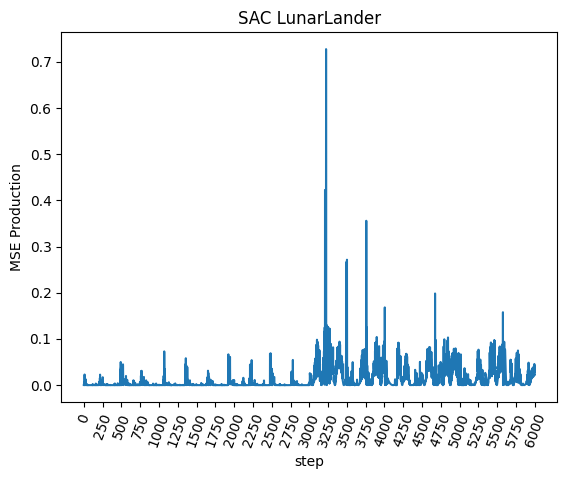

In [13]:
plt.plot(np.array(mses_production))
plt.xlabel("step")
plt.ylabel("MSE Production")
plt.title("SAC LunarLander")
plt.xticks(np.arange(0, 6001, 250), rotation=70)
plt.show()

### Environment Drift Detection with Prob CUSUM

In [14]:
class CusumMeanDetector():
  def __init__(self, mu_ref, sigma_ref, obs_ref, p_limit=0.01) -> None:
    self._mu_ref = mu_ref
    self._sigma_ref = sigma_ref
    self._p_limit = p_limit

    self._reset(obs_ref)

  def _reset(self, obs_ref) -> None:
    self.current_t = len(obs_ref)
    self.current_obs = obs_ref.copy()
    #self.mu_current = self._mu_ref
    #self.sigma_current = self._sigma_ref

  def _update_data(self, y:float) -> None:
    self.current_t += 1
    self.current_obs.append(y)

  def _get_pvalue(self, y, alternative="two-sided") -> float:
    assert alternative in {"two-sided", "greater", "less"}
    pcum = scipy.stats.norm.cdf(y, loc=0., scale=1.)
    if alternative == "two-sided":
      p = 2*(1-pcum)
    if alternative == "greater":
      p = 1-pcum
    if alternative == "less":
      p = pcum
    return p

  def _check_for_changepoint(self, alternative) -> Tuple[float, bool]:
    standardized_sum = np.sum(np.array(self.current_obs)-self._mu_ref)/(self._sigma_ref*self.current_t**0.5)
    p = self._get_pvalue(standardized_sum, alternative)
    return p, p < self._p_limit


  def predict_next(self, y, alternative="two-sided") -> Tuple[float, bool]:
    self._update_data(y)
    p, is_changepoint = self._check_for_changepoint(alternative)
    return p, is_changepoint

In [15]:
# Environment Drift Detection with CUSUM
env0_steps = 4000
window_size = 200
mses_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)


  ## Transform the action label
  if action_t[0] < 0:
    action_t_main = -1e-5
  else:
    action_t_main = action_t[0]
  if action_t[1] < 0.5 and action_t[1] > -0.5:
    action_t_side =0
  #elif action_t[1] <= -0.5:
  #  action_t_side = action_t[1] + 0.45
  #else:
  #  action_t_side = action_t[1] - 0.45
  else:
    action_t_side = action_t[1]


  action_t_label = np.array([action_t_main, action_t_side])


  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_reference.append(mse(action_t_label, action_t_pre.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

#print(f"Reference mean: {np.mean(mses_reference)}, Reference std: {np.std(mses_reference)}")

mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)
mses_reference_window = np.random.choice(mses_reference, size=window_size, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref = sigma_ref,
                                   obs_ref=mses_reference_window,
                                   p_limit = p_limit)

false_postives = 0
delay = 4000

for i,val in enumerate(mses_production):
  #drift_detector.add_data_point(val)
  p_value, drift_detected = drift_detector.predict_next(val, alternative="greater")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val}")
    mses_reference_window = np.random.choice(mses_reference, size=window_size, replace=False).tolist()
    drift_detector._reset(mses_reference_window)
    if i<3000:
      false_postives+=1
    if i >= 3000:
      delay = i-3000
      break

print(f"False Alarms: {false_postives}, Delay: {delay}")

Drift Detected at: 3091 with value: 0.08698254823684692
False Alarms: 0, Delay: 91


### Page Hinkley

In [16]:
ph = drift.PageHinkley(mode="up", delta=0.005)

env0_steps = 4000
mses_reference = []
p_limit = 0.05
obs_t,_ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)


  ## Transform the action label
  if action_t[0] < 0:
    action_t_main = -1e-5
  else:
    action_t_main = action_t[0]
  if action_t[1] < 0.5 and action_t[1] > -0.5:
    action_t_side =0
  #elif action_t[1] <= -0.5:
  #  action_t_side = action_t[1] + 0.45
  #else:
  #  action_t_side = action_t[1] - 0.45
  else:
    action_t_side = action_t[1]


  action_t_label = np.array([action_t_main, action_t_side])


  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_reference.append(mse(action_t_label, action_t_pre.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  ph.update(val)
  if ph.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 522, input value: 4.902061698108761
Change detected at index 1376, input value: 4.631087927144505
Change detected at index 1944, input value: 7.041428931611913
Change detected at index 2501, input value: 1.254747840863278
Change detected at index 3068, input value: 2.472621697778244
False Alarms: 4, Delay: 68


### ADWIN

In [17]:
adwin = drift.ADWIN()

env0_steps = 4000
mses_reference = []
#p_limit = 0.05
obs_t,_ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)


  ## Transform the action label
  if action_t[0] < 0:
    action_t_main = -1e-5
  else:
    action_t_main = action_t[0]
  if action_t[1] < 0.5 and action_t[1] > -0.5:
    action_t_side =0
  #elif action_t[1] <= -0.5:
  #  action_t_side = action_t[1] + 0.45
  #else:
  #  action_t_side = action_t[1] - 0.45
  else:
    action_t_side = action_t[1]


  action_t_label = np.array([action_t_main, action_t_side])



  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_reference.append(mse(action_t_label, action_t_pre.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  adwin.update(val)
  if adwin.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break


print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 2527, input value: 2.5176101308629115
Change detected at index 3103, input value: 7.569776535154505
False Alarms: 1, Delay: 103


### KSWIN

In [18]:
kswin = drift.KSWIN()

env0_steps = 4000
mses_reference = []
#p_limit = 0.05
obs_t,_ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)


  ## Transform the action label
  if action_t[0] < 0:
    action_t_main = -1e-5
  else:
    action_t_main = action_t[0]
  if action_t[1] < 0.5 and action_t[1] > -0.5:
    action_t_side =0
  #elif action_t[1] <= -0.5:
  #  action_t_side = action_t[1] + 0.45
  #else:
  #  action_t_side = action_t[1] - 0.45
  else:
    action_t_side = action_t[1]


  action_t_label = np.array([action_t_main, action_t_side])


  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  x = np.concatenate([obs_t, obs_tplus1-obs_t]).reshape(1,-1)
  x = scaler.transform(x)
  x = torch.from_numpy(x.astype("float32")).to(device)
  action_t_pre = model_gp_env0(x)
  mses_reference.append(mse(action_t_label, action_t_pre.mean.flatten().detach().cpu().numpy()))

  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()


mu_ref = np.mean(mses_reference)
sigma_ref = np.std(mses_reference, ddof=1)

mses_production_norm = (mses_production-mu_ref)/sigma_ref


false_alarms = 0
delay = 4000

for i, val in enumerate(mses_production_norm):
  kswin.update(val)
  if kswin.drift_detected and val>0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break


print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 764, input value: 0.06329674672959919
Change detected at index 1129, input value: 0.04985559900671865
Change detected at index 2525, input value: 2.11355873027342
Change detected at index 2762, input value: 3.6896333166862187
Change detected at index 3105, input value: 6.593460295975816
False Alarms: 4, Delay: 105
